# Long-lived RecB spots

In [2]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context
import pandas as pd

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1', '240612_1', '240620_1',
                            '230817_1', '230810_1', '230816_1', '240717_3',
                            '230906_2', '230912_1', '230912_2', '240620_3', '240717_1', '240717_2',
                            '230907_1', '230907_2', '230913_1', '240717_4',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2', '240612_2', '240620_2'
                            ],
                    groups=['0', '0', '0', '0', '0', '0', '0', '0',
                            '3 ng/mL', '3 ng/mL', '3 ng/mL', '3 ng/mL',
                            '10 ng/mL', '10 ng/mL', '10 ng/mL', '10 ng/mL', '10 ng/mL', '10 ng/mL',
                            '20 ng/mL', '20 ng/mL', '20 ng/mL', '20 ng/mL',
                            '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL'
                            ],
                    metadata='DateTime',
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        )

Dataset 230725_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230817_1 (group 3 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230810_1 (group 3 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230816_1 (group 3 ng/mL): loa

In [ ]:
data.describe()

## JF549 bleaching rates

Fit the bleaching rate for each dataset (might be different due to e.g. changes in laser power over time).

The bleaching rates will be used below to determine the dissociation rate of RecB from DNA.

In [3]:
bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR',
                    groupby=['Group', 'Dataset'], model_type='monoexp_decay_offset',
                    p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

bleaching_rates = (bleaching_fit.parameters
                   .query('Parameter == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Value.div(2))  # Divide by 2 to adjust for exposure time
                   )

# (
#     so.Plot(bleaching_fit.data, x='Frame', color='Group')
#     .layout(size=(15, 6))
#     .facet(col='Dataset', wrap=6)
#     .add(so.Dots(marker='.', fillalpha=1), so.Agg(), y='SNR')
#     .add(so.Line(linestyle='-'), y='Fit', legend=False)
#     .scale(color='flare')
#     .share(y=False)
#     .limit(x=(None, None), y=(None, None))
#     .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='', title='')
#     # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_fits_cipro0.svg', format='svg', bbox_inches='tight')
# )

Show fitted parameters

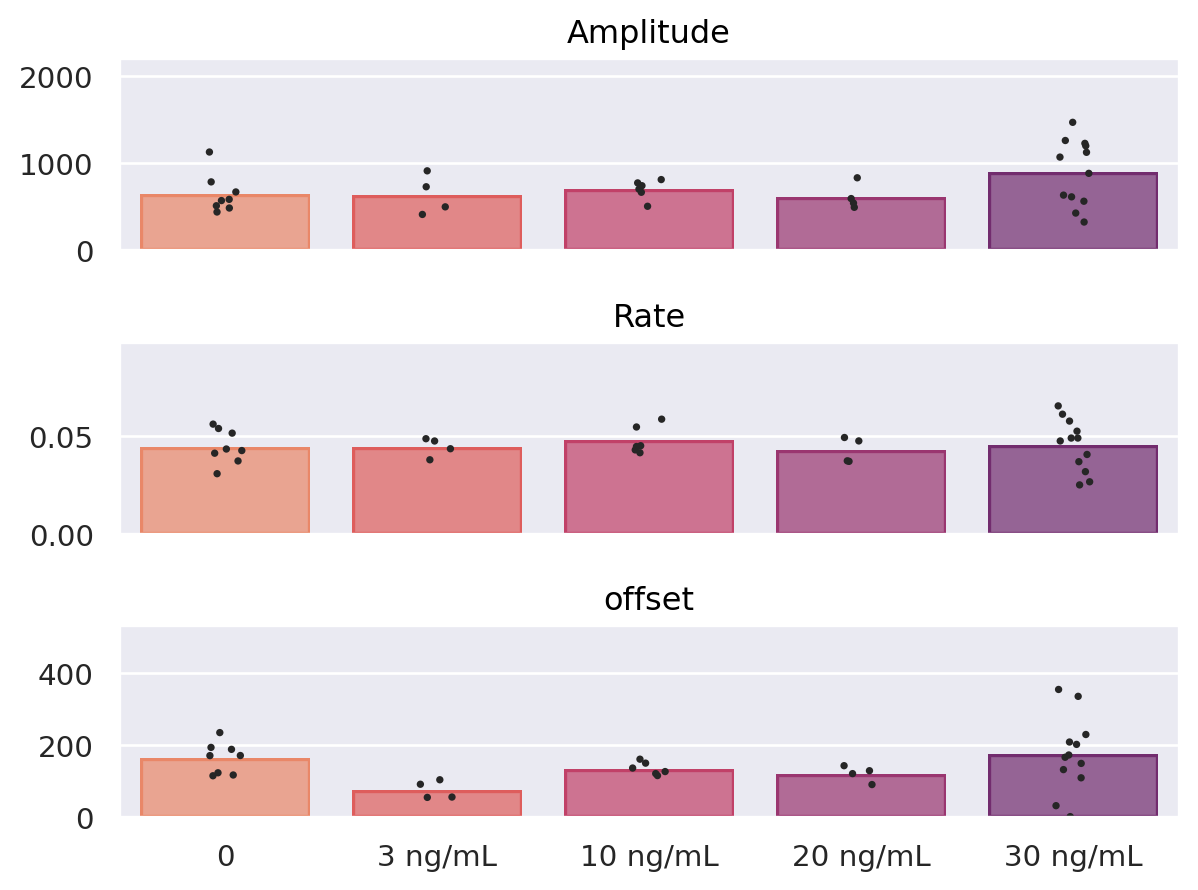

In [3]:
(
    so.Plot(bleaching_fit.parameters, x='Group', y='Value', color='Group')
    .facet(row='Parameter')
    .add(so.Bar(), so.Agg(), legend=False)
    .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

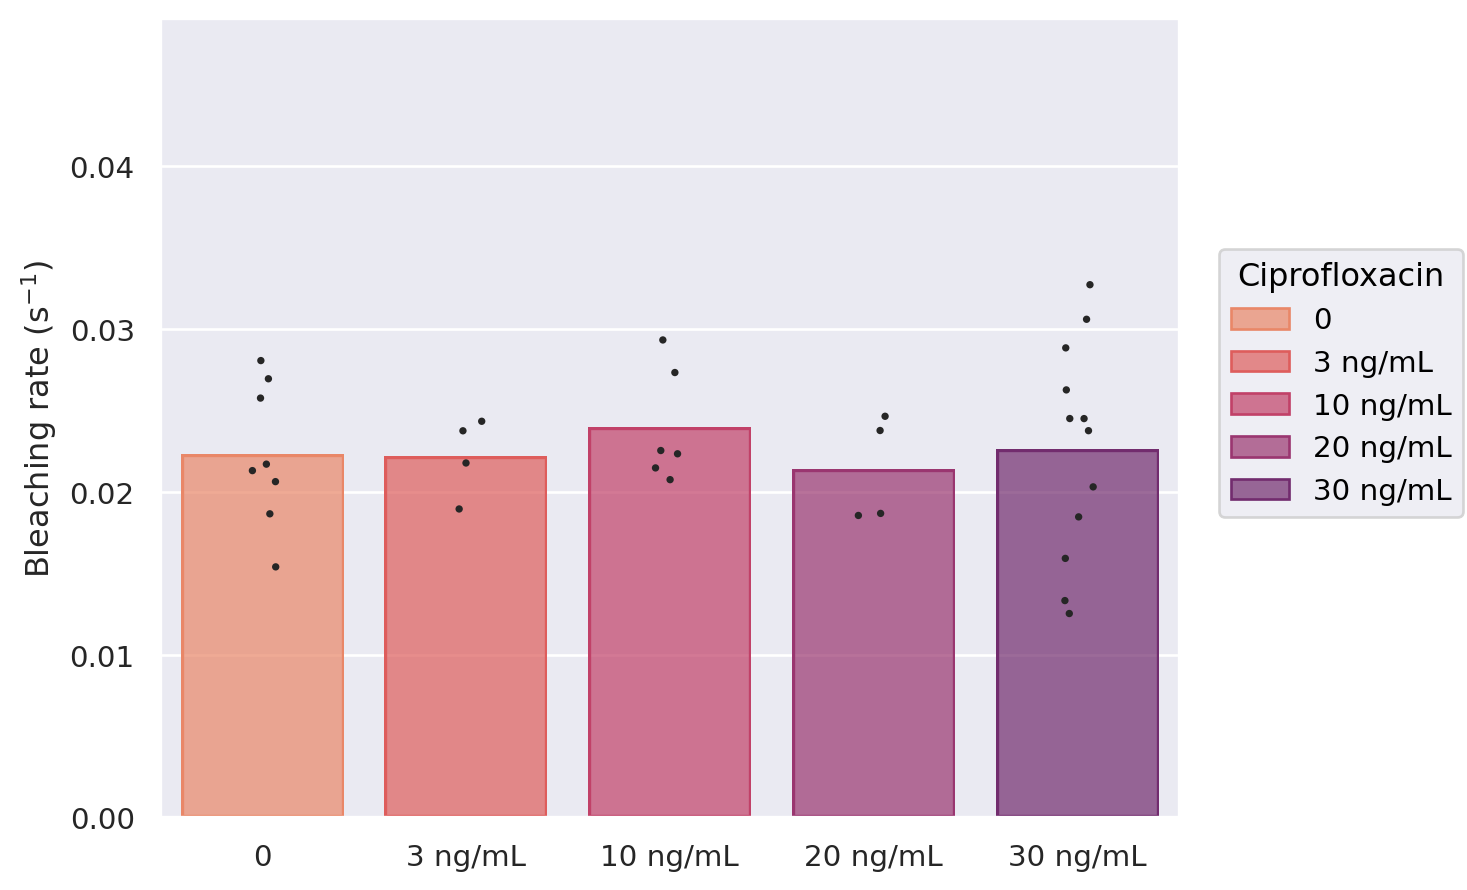

In [4]:
(
    so.Plot(bleaching_rates, x='Group', y='Adjusted_rate', color='Group')
    .add(so.Bar(), so.Agg())
    .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="Bleaching rate (s$^{-1}$)", color='Ciprofloxacin')
    .theme({'axes.ymargin':0.5})
    # .save(loc='M:\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

## RecB binding time on DNA

### A mono-exponential decay model does not fit the histograms well (especially under higher ciprofloxacin)

In [6]:
hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'],
                     density=True, discrete=False, binlabels='left')                     
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Group', 'Dataset'], p0=[1, 0.1])

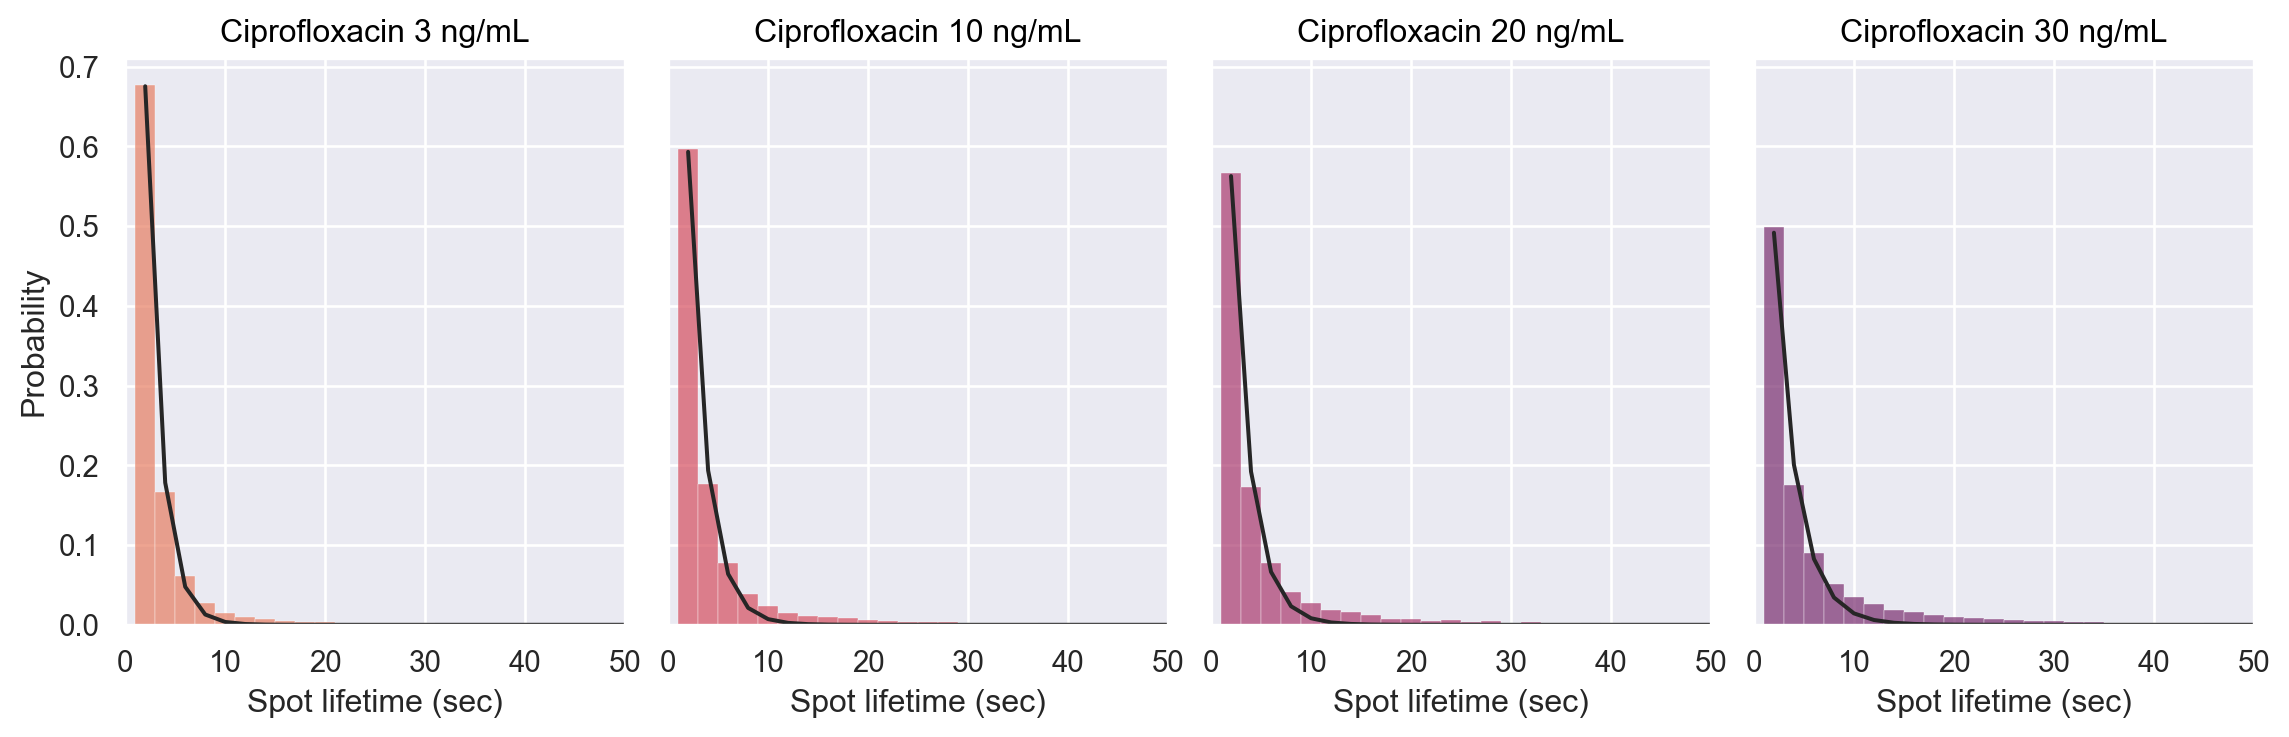

In [7]:
df = (monoexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      .query('Group != "0"')
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .layout(size=(12, 4))
    .facet(col='Group', wrap=4)
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 50), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    # .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Monoexp_fits_cipro.pdf', format='pdf', bbox_inches='tight')
)

### Fitting with a bi-exponential model gives better results

Bootstrapping helps eliminate random variations by performing each fit 100 times, and taking the median fitted value for each parameter.

In [4]:
from pyberries.data import get_model

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'],
                     density=True, discrete=False, binlabels='left')                     
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay', bootstrap_samples=100,
                   groupby=['Group', 'Dataset'], p0=[1, 1, 0.1, 0.1])

monoexp_decay = get_model('monoexp_decay')

lifetime_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = lifetime_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

Group ('0', '230725_1'): 3 iterations failed
Group ('0', '230725_2'): 4 iterations failed
Group ('0', '230126_DT23'): 4 iterations failed
Group ('0', '230719_1'): 11 iterations failed
Group ('0', '240424_1'): 3 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('0', '240612_1'): 28 iterations failed
Group ('0', '240620_1'): 29 iterations failed
Group ('3 ng/mL', '230817_1'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('3 ng/mL', '230810_1'): 2 iterations failed
Group ('3 ng/mL', '230816_1'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('10 ng/mL', '230906_2'): 15 iterations failed
Group ('10 ng/mL', '230912_1'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('10 ng/mL', '230912_2'): 2 iterations failed
Group ('10 ng/mL', '240620_3'): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('10 ng/mL', '240717_1'): 1 iterations failed
Group ('10 ng/mL', '240717_2'): 3 iterations failed
Group ('20 ng/mL', '230907_1'): 1 iterations failed
Group ('20 ng/mL', '230907_2'): 1 iterations failed
Group ('20 ng/mL', '230913_1'): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('30 ng/mL', '230118_DT23'): 6 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('30 ng/mL', '230726_cipro30'): 3 iterations failed
Group ('30 ng/mL', '230824_1'): 2 iterations failed
Group ('30 ng/mL', '230829_1'): 4 iterations failed
Group ('30 ng/mL', '230201_DT23'): 1 iterations failed
Group ('30 ng/mL', '230718_2sec'): 1 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('30 ng/mL', '240424_2'): 4 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('30 ng/mL', '240612_2'): 3 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('30 ng/mL', '240620_2'): 1 iterations failed


Show the fits (with monoexponential components)

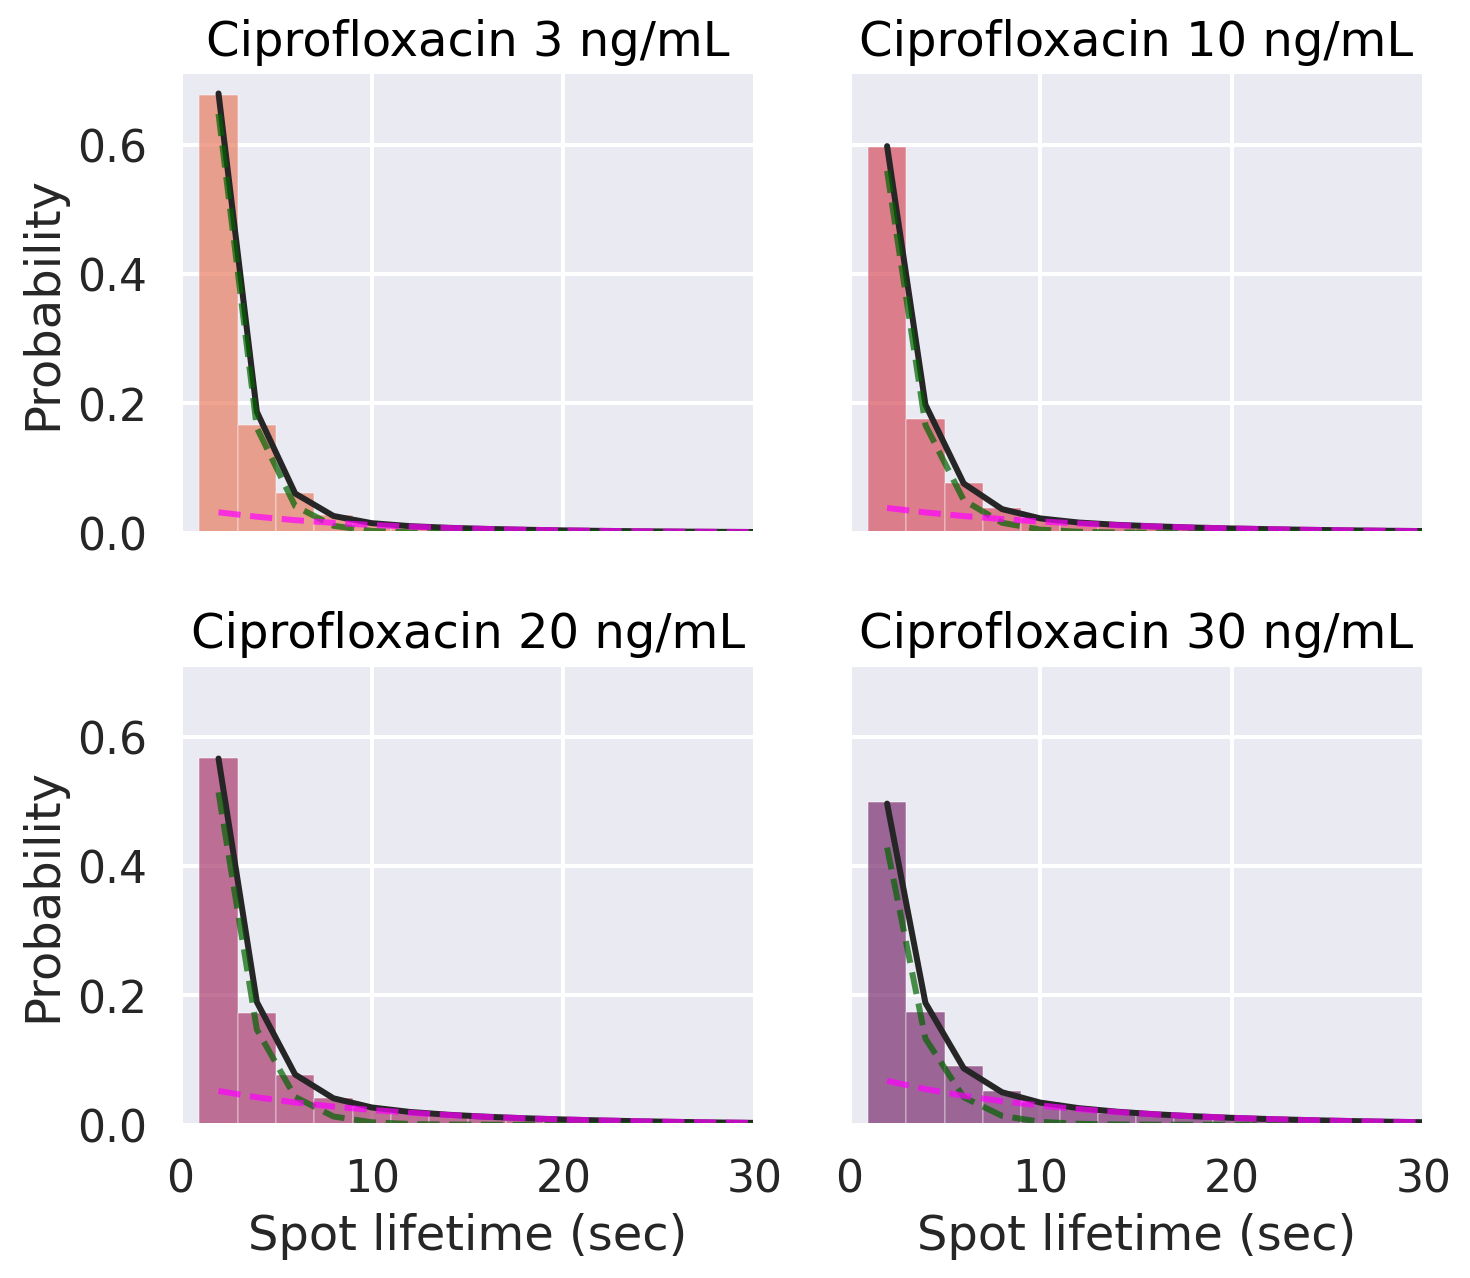

In [5]:
df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      .query('Group != "0"')
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .layout(size=(8, 7))
    .facet(col='Group', wrap=2)
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    .theme(plotting_context('talk'))
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes_fits.svg', format='svg', bbox_inches='tight')
)

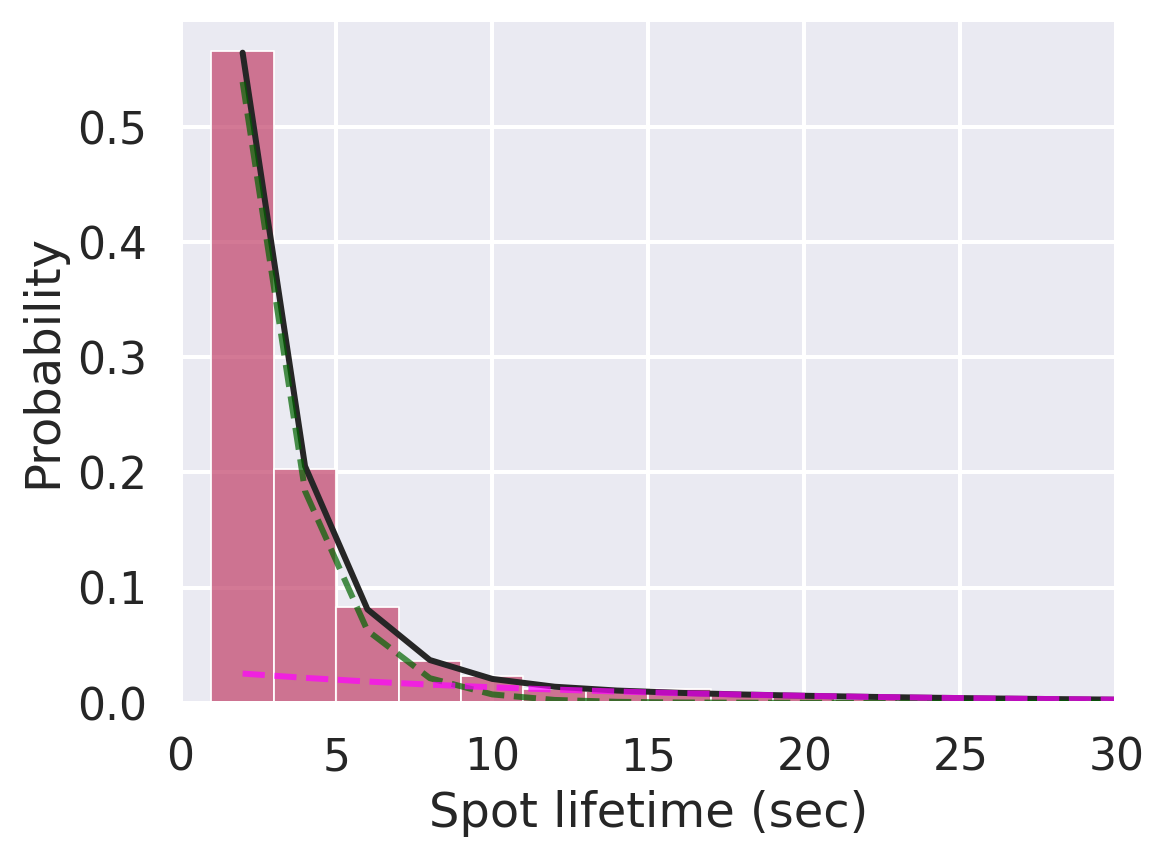

In [6]:
df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      .query('Dataset == "240717_1"')
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes_fits.svg', format='svg', bbox_inches='tight')
)

Calculate spot lifetimes by taking into account the frame time (2 sec) and bleaching rates

Calculate Short- and Long-lived populations from the fit amplitudes

In [8]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes = (lifetime_fit
             .parameters
             .copy()
             .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
             .replace({'1':'Short', '2':'Long'})
             .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
             .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
             .reset_index()
             .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                     Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                     Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                     Population_Short=lambda df: 100 - df.Population_Long
                     )
             .drop(columns=['Value', 'Value_bleaching'], level=0)
             .droplevel(['Parameter', 'Rate_type'], axis=1)
             .melt(id_vars=['Group', 'Dataset'])
             .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
             .drop(columns='variable')
             .assign(Group=lambda df: df.Group
                                        .astype('category')
                                        .cat.set_categories(['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'], ordered=True))
             .sort_values('Group')
             )

Spot lifetimes (both short and long-lived spots)

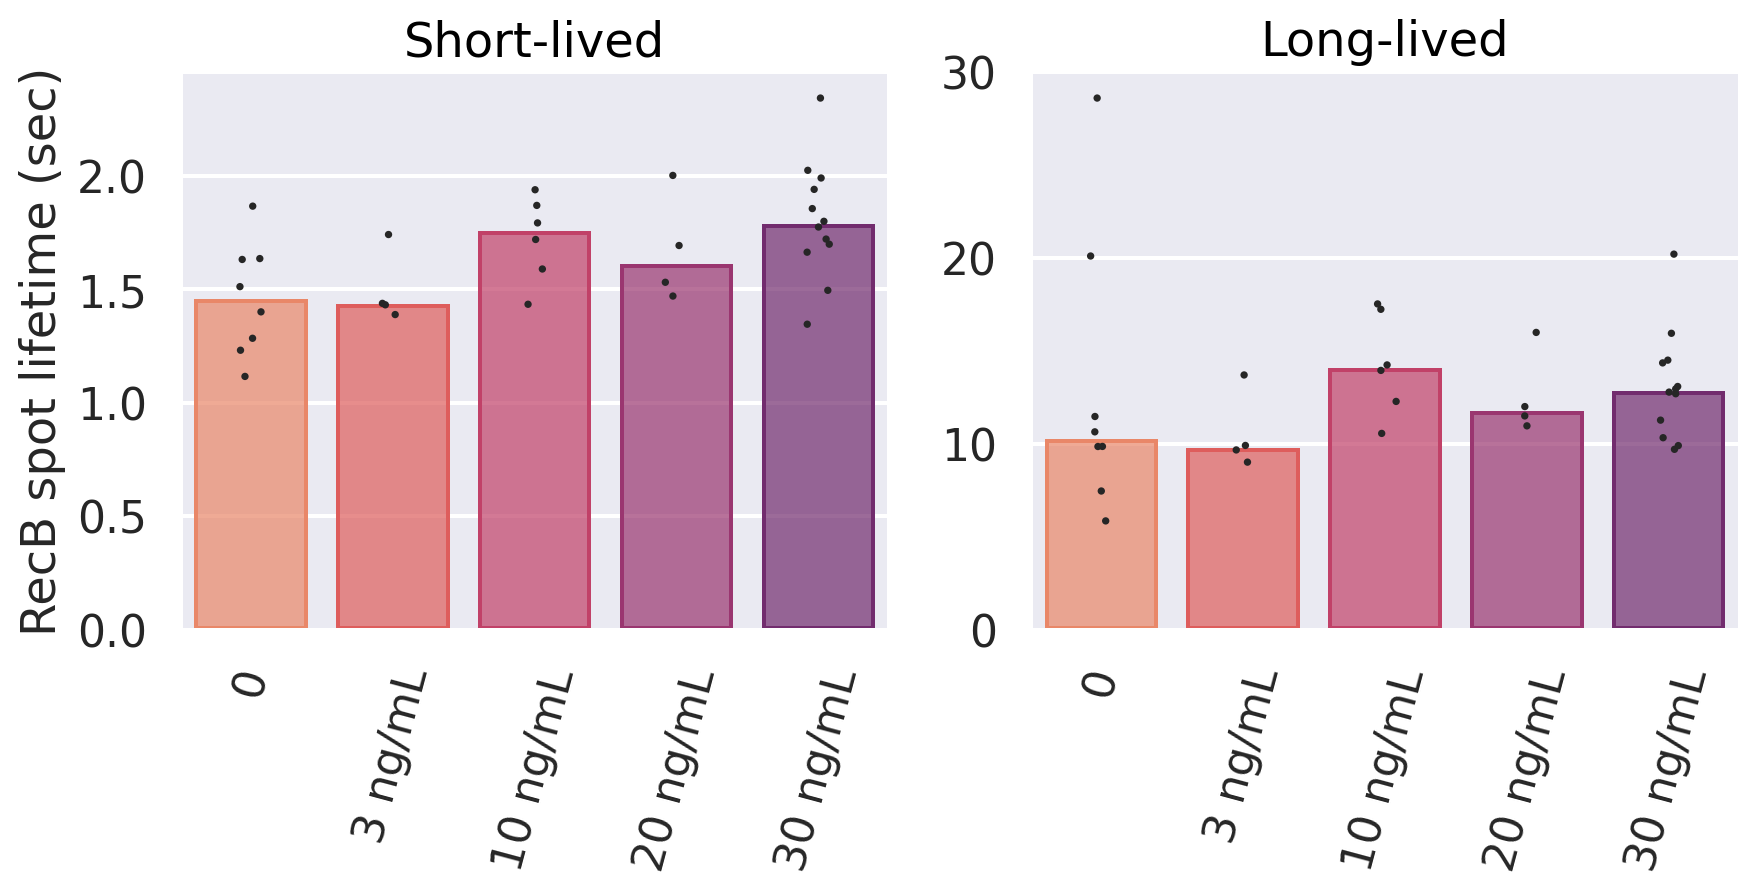

In [9]:
p = (
    so.Plot(lifetimes.query('Parameter == "Lifetime"'), x='Group', y='value', color='Group')
    .layout(size=(9.5,5))
    .facet(col='Rate_type')
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare'))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="RecB spot lifetime (sec)", color='Ciprofloxacin', title='{}-lived'.format)
    .theme(plotting_context('talk'))
    .plot()
)

p._figure.axes[0].xaxis.set_tick_params(rotation=75)
p._figure.axes[1].xaxis.set_tick_params(rotation=75)

display(p)
# p.save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')

Proportion of long-lived spots

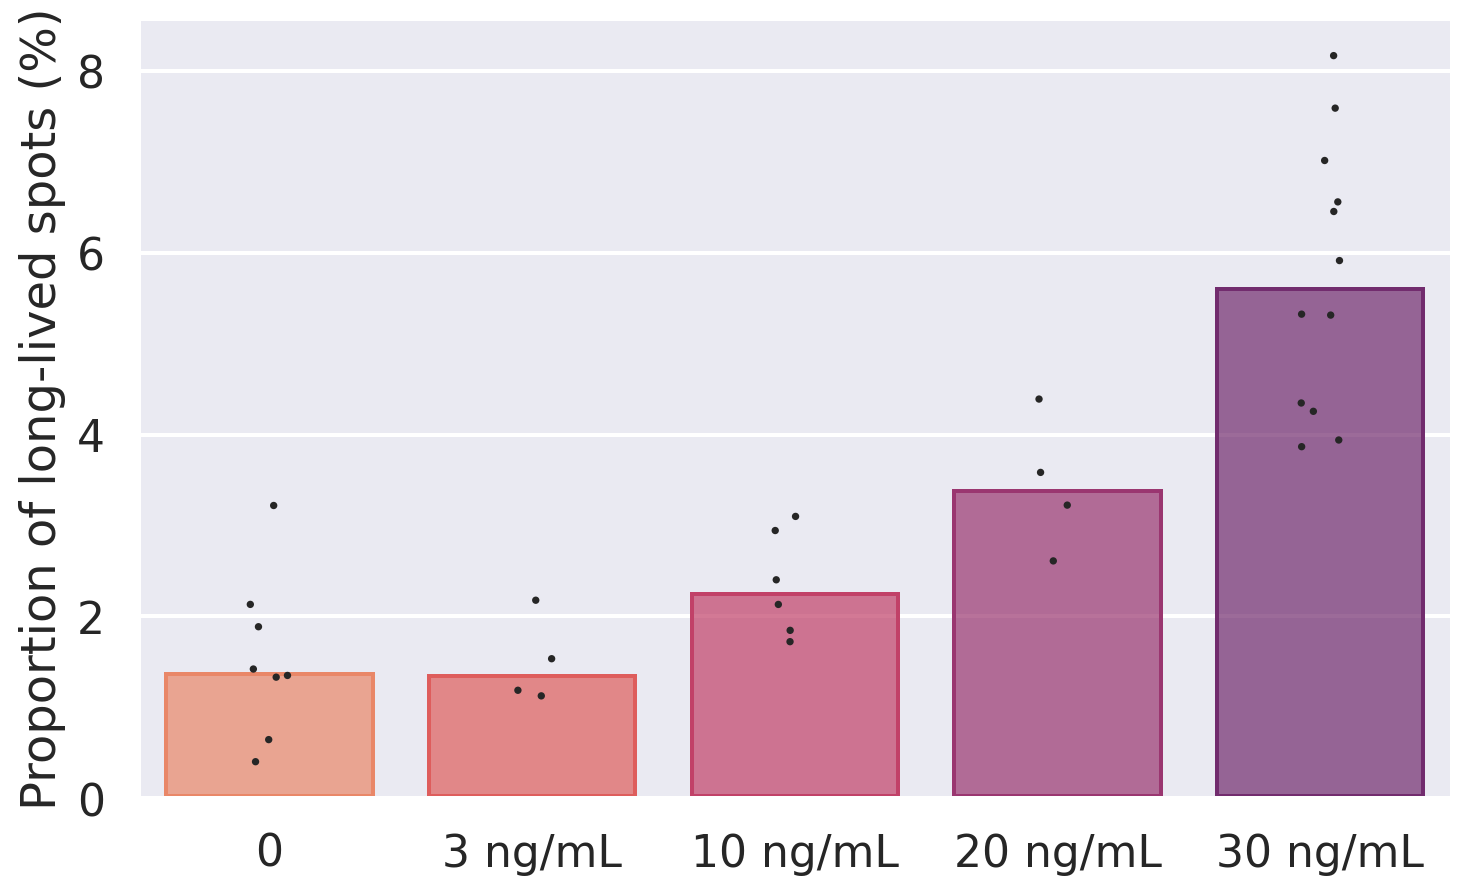

In [10]:
df = (lifetimes
      .query('Parameter == "Population" and Rate_type == "Long"')
      .assign(value=lambda df: df.value)
      )

(
    so.Plot(df, x='Group', y='value', color='Group')
    .layout(size=(8,5))
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(0, None))
    .label(x="", y="Proportion of long-lived spots (%)", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Proportion_long_spots.svg', format='svg', bbox_inches='tight')
)

#### Estimate of the rate of RecB recruitment to DNA

We can estimate the rate of recruitment of RecB to DNA by counting how many long-lived spots appear (on average per dataset) over our 100 sec timelapse.

See further below for an estimate of recruitment rate at different time-points post ciprofloxacin exposure.

DSB_rate     
           median  std
Group                 
0             0.7  0.7
3 ng/mL       1.1  0.2
10 ng/mL      1.8  1.0
20 ng/mL      2.4  1.2
30 ng/mL      5.1  2.6

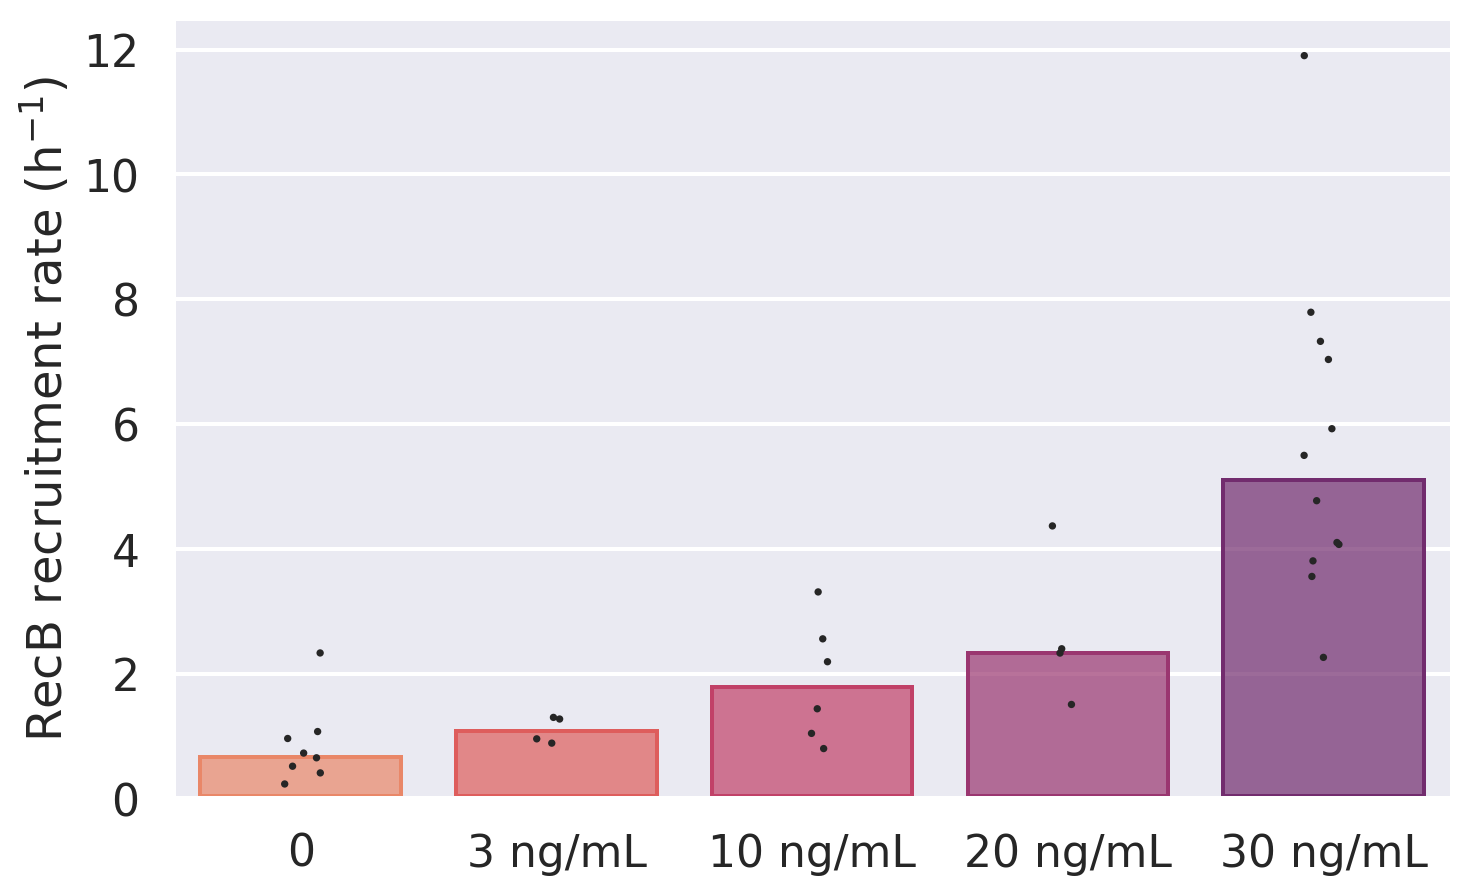

In [16]:
df = (data
      .RecB_spots
      .query('Time_min_bin < 90 and Frame > 0')
      .groupby(by=['Group', 'Dataset', 'ParentIndices'])
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Dataset'])
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .groupby(['Dataset'])
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),
             on=['Group', 'Dataset']
             )
      .assign(DSB_rate=lambda df: df.norm_count /98*60*60 *df.long_lived)  # Rate of DSB formation (h-1)
      )

display(df
        .assign(Group=lambda df: df.Group
                                   .astype('category')
                                   .cat.set_categories(['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'], ordered=True))
        .sort_values('Group')
        .groupby('Group', observed=True)
        .agg({'DSB_rate':['median', 'std']})
        .round(1)
        )

(
    so.Plot(df, x='Group', y='DSB_rate', color='Group')
    .layout(size=(8,5))
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL']),
           x=so.Nominal(order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'])
           )
    .share(y=False)
    .limit(y=(0, None))
    .label(x="", y="RecB recruitment rate (h$^{-1}$)", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/DSB_rate.svg', format='svg', bbox_inches='tight')
)

Fit parameters table

In [12]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Group', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Group', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(2)
      .pipe(lambda df: fuse_cols(df, cols=['Lifetime_mean', 'Lifetime_std'], new='Lifetime (sec)', delimiter=' $\pm$ '))
      .pipe(lambda df: fuse_cols(df, cols=['Population_mean', 'Population_std'], new='Proportion (\%)', delimiter=' $\pm$ '))
      [['Lifetime (sec)', 'Proportion (\%)']]
      .rename_axis(['Ciprofloxacin', 'Population'])
      .reindex(['Short', 'Long'], level=1)
      )

display(df)
print(df.to_latex())

Lifetime (sec)   Proportion (\%)
Ciprofloxacin Population                                    
0             Short        1.46 $\pm$ 0.25  98.45 $\pm$ 0.88
              Long        12.97 $\pm$ 7.59   1.55 $\pm$ 0.88
3 ng/mL       Short         1.5 $\pm$ 0.16  98.49 $\pm$ 0.48
              Long        10.57 $\pm$ 2.12   1.51 $\pm$ 0.48
10 ng/mL      Short        1.72 $\pm$ 0.19  97.64 $\pm$ 0.57
              Long        14.29 $\pm$ 2.73   2.36 $\pm$ 0.57
20 ng/mL      Short        1.67 $\pm$ 0.24  96.55 $\pm$ 0.74
              Long        12.61 $\pm$ 2.29   3.45 $\pm$ 0.74
30 ng/mL      Short        1.81 $\pm$ 0.26  94.27 $\pm$ 1.46
              Long        13.13 $\pm$ 2.94   5.73 $\pm$ 1.46

\begin{tabular}{llll}
\toprule
 &  & Lifetime (sec) & Proportion (\%) \\
Ciprofloxacin & Population &  &  \\
\midrule
\multirow[t]{2}{*}{0} & Short & 1.46 $\pm$ 0.25 & 98.45 $\pm$ 0.88 \\
 & Long & 12.97 $\pm$ 7.59 & 1.55 $\pm$ 0.88 \\
\cline{1-4}
\multirow[t]{2}{*}{3 ng/mL} & Short & 1.5 $\pm$ 0.16 & 98.49 $\pm$ 0.48 \\
 & Long & 10.57 $\pm$ 2.12 & 1.51 $\pm$ 0.48 \\
\cline{1-4}
\multirow[t]{2}{*}{10 ng/mL} & Short & 1.72 $\pm$ 0.19 & 97.64 $\pm$ 0.57 \\
 & Long & 14.29 $\pm$ 2.73 & 2.36 $\pm$ 0.57 \\
\cline{1-4}
\multirow[t]{2}{*}{20 ng/mL} & Short & 1.67 $\pm$ 0.24 & 96.55 $\pm$ 0.74 \\
 & Long & 12.61 $\pm$ 2.29 & 3.45 $\pm$ 0.74 \\
\cline{1-4}
\multirow[t]{2}{*}{30 ng/mL} & Short & 1.81 $\pm$ 0.26 & 94.27 $\pm$ 1.46 \\
 & Long & 13.13 $\pm$ 2.94 & 5.73 $\pm$ 1.46 \\
\cline{1-4}
\bottomrule
\end{tabular}



### Fit timepoints independently by pooling datasets

The goal here is to fit the different time-points post ciprofloxacin exposure separately. Replicate datasets are pooled to increase statistics.

Bootstrapping was essential here so fits don't fall into local minima, producing inconsistent values.

In [30]:
from pyberries.data import get_model

hist = (get_histogram(data.RecB_spots.query('Time_min_bin < 90'), col='TrackLength', binsize=1, groupby=['Group', 'Time_min_bin'], density=True, discrete=False, binlabels='left')
        )
fit_timepoints = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                     bootstrap_samples=100,
                     groupby=['Group', 'Time_min_bin'], p0=[1, 1, 0.1, 0.1])


monoexp_decay = get_model('monoexp_decay')

fit_timepoints.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for grp, df in fit_timepoints.data.groupby(['Group', 'Time_min_bin']):
    cip, t = grp
    t = str(t)
    params = fit_timepoints.parameters.query('Time_min_bin == @t and Group == @cip')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    fit_timepoints.data.loc[(fit_timepoints.data.Time_min_bin == float(t)) & (fit_timepoints.data.Group == cip),:] = df

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('0', 30.0): 7 iterations failed
Group ('0', 60.0): 3 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('0', 75.0): 25 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('3 ng/mL', 60.0): 1 iterations failed
Group ('3 ng/mL', 75.0): 9 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('10 ng/mL', 15.0): 4 iterations failed
Group ('20 ng/mL', 15.0): 2 iterations failed


/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Group ('30 ng/mL', 75.0): 1 iterations failed


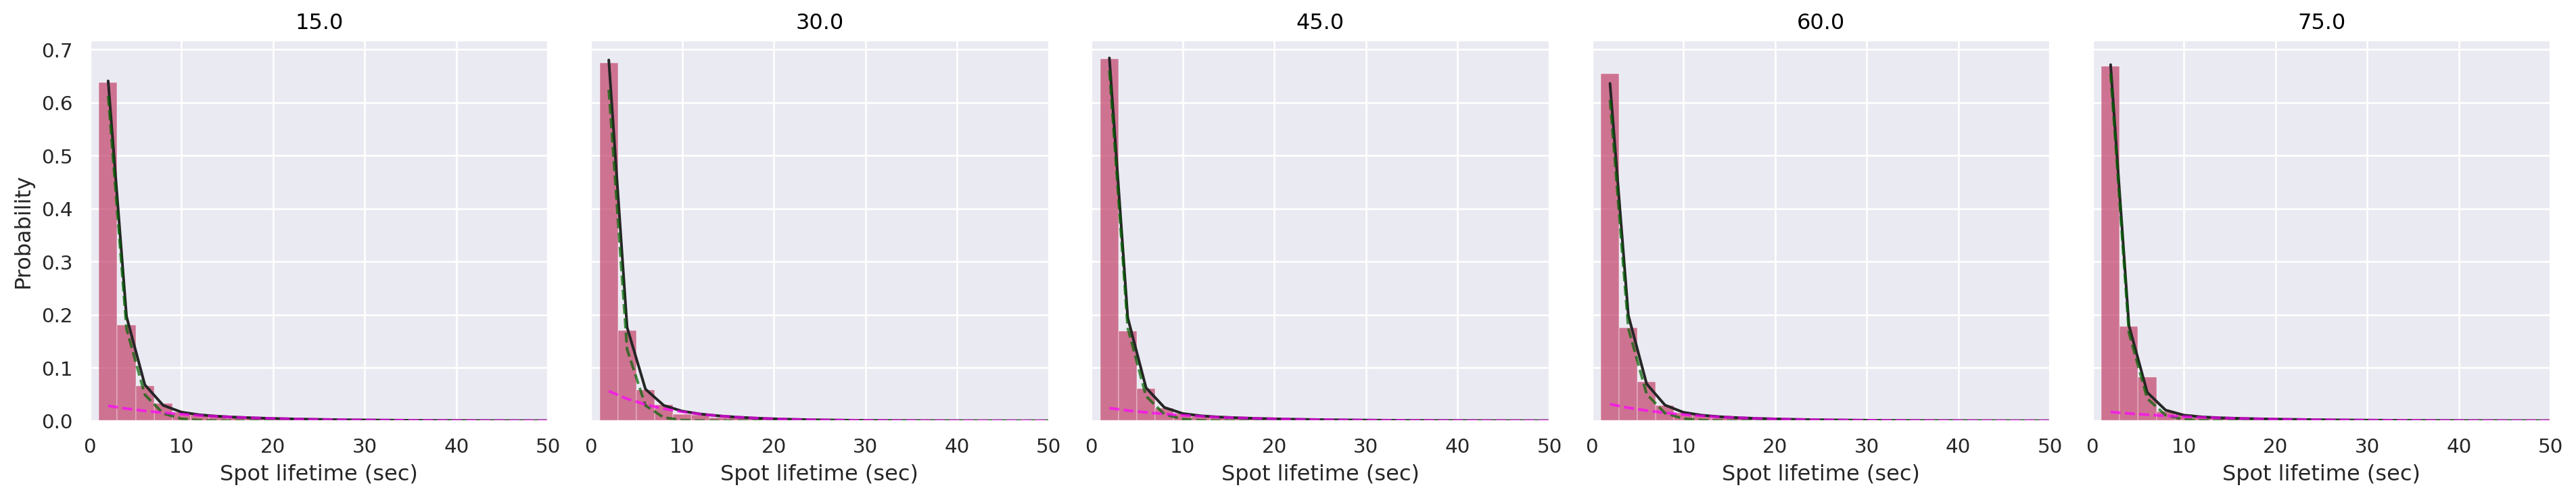

In [31]:
df = (fit_timepoints
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      .query('Group == "0"')
      )

(
    so.Plot(df, x='TrackLength_s', y='proportion', color='Group')
    .layout(size=(20, 4))
    .facet(col='Time_min_bin')
    .add(so.Bars(), legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 50), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability")
)

In [32]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_timepoints = (fit_timepoints
                        .parameters
                        .copy()
                        .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                        .replace({'1':'Short', '2':'Long'})
                        .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Time_min_bin'], columns=['Parameter', 'Rate_type']))
                        .reset_index()
                        .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short) *2,
                                Lifetime_Long=lambda df: 1/(df.Value.Rate.Long) *2,
                                Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                                Population_Short=lambda df: 100 - df.Population_Long
                                )
                        .drop(columns=['Value'], level=0)
                        .droplevel(['Parameter', 'Rate_type'], axis=1)
                        .melt(id_vars=['Group', 'Time_min_bin'])
                        .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                        .drop(columns='variable')
                        .assign(Group=lambda df: df.Group
                                                        .astype('category')
                                                        .cat.set_categories(['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'], ordered=True))
                        .sort_values('Group')
                        )

#### Proportion of long-lived spots

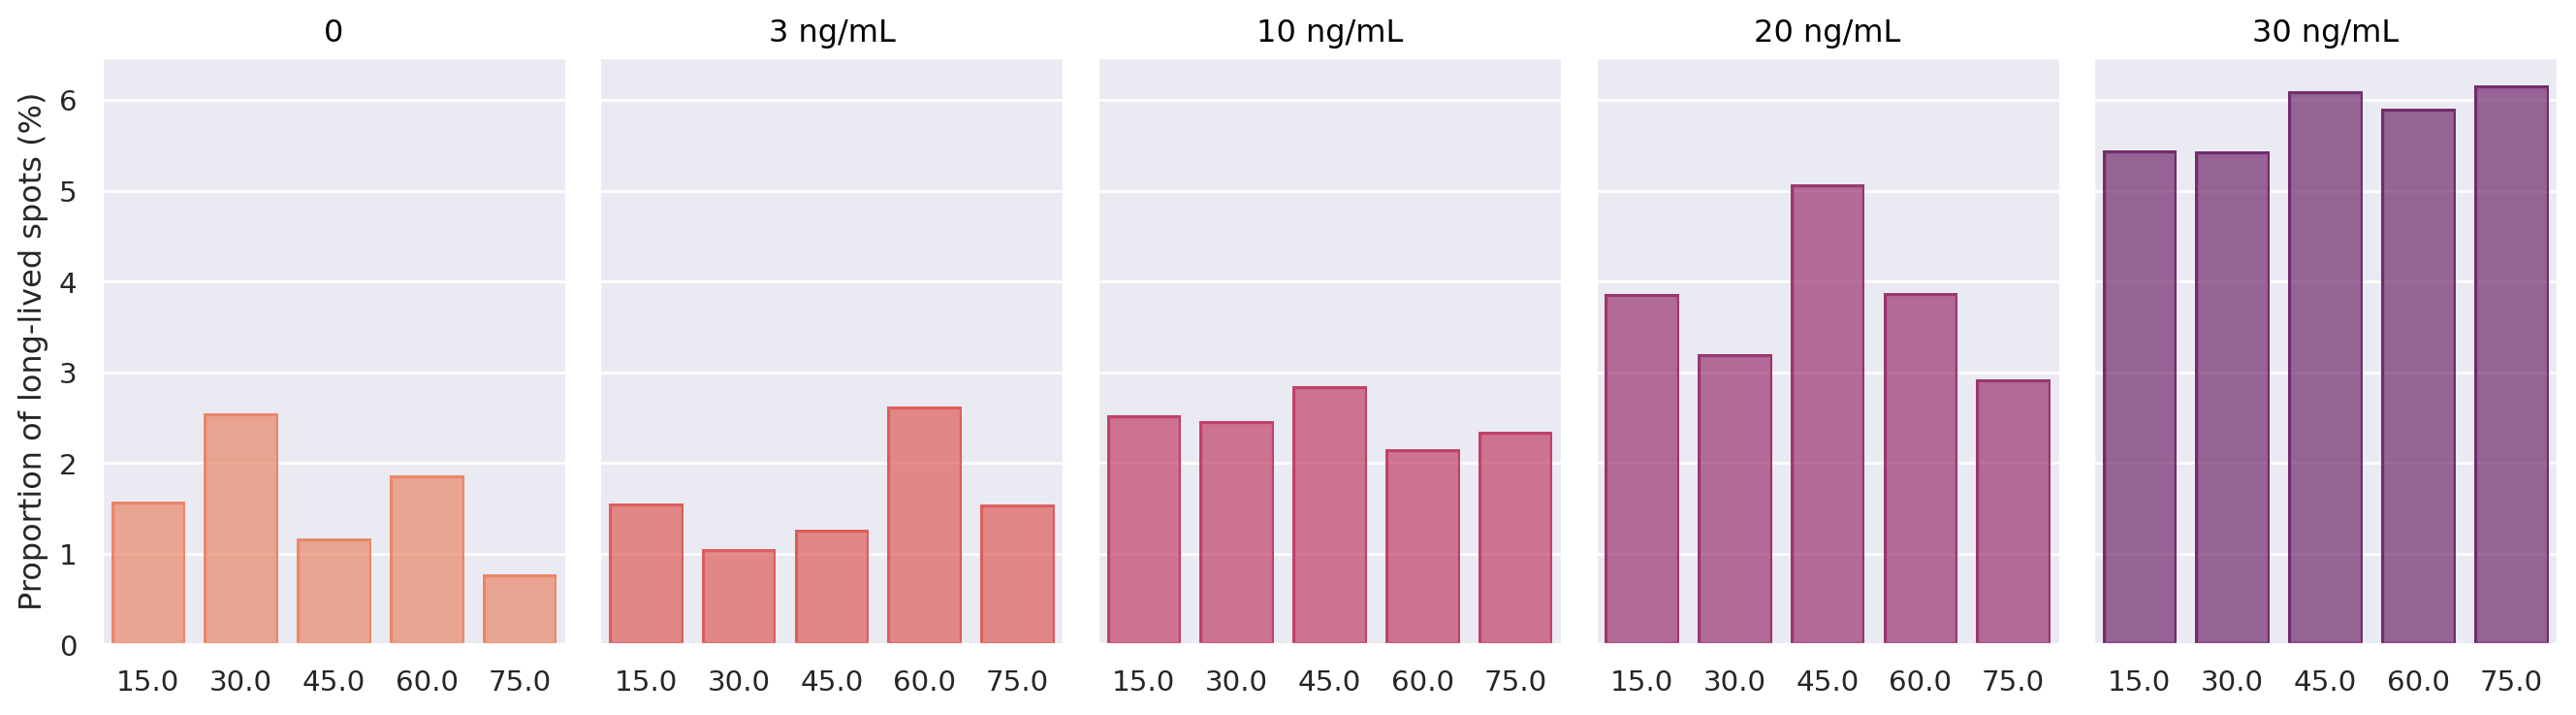

In [33]:
df = (lifetimes_timepoints
      .query('Parameter == "Population" and Rate_type == "Long"')
    #   .assign(value=lambda df: df.value - 1.71)
      )

(
    so.Plot(df, x='Time_min_bin', y='value', color='Group')
    .layout(size=(14, 4))
    .facet(col='Group')
    .add(so.Bar(), so.Agg(), legend=False)
    .scale(color='flare')
    .limit(y=(0, None))
    .label(x="", y="Proportion of long-lived spots (%)", color='Ciprofloxacin')
    # .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Proportion_long_spots.svg', format='svg', bbox_inches='tight')
)

#### Estimate of the rate of recruitment of RecB on DNA

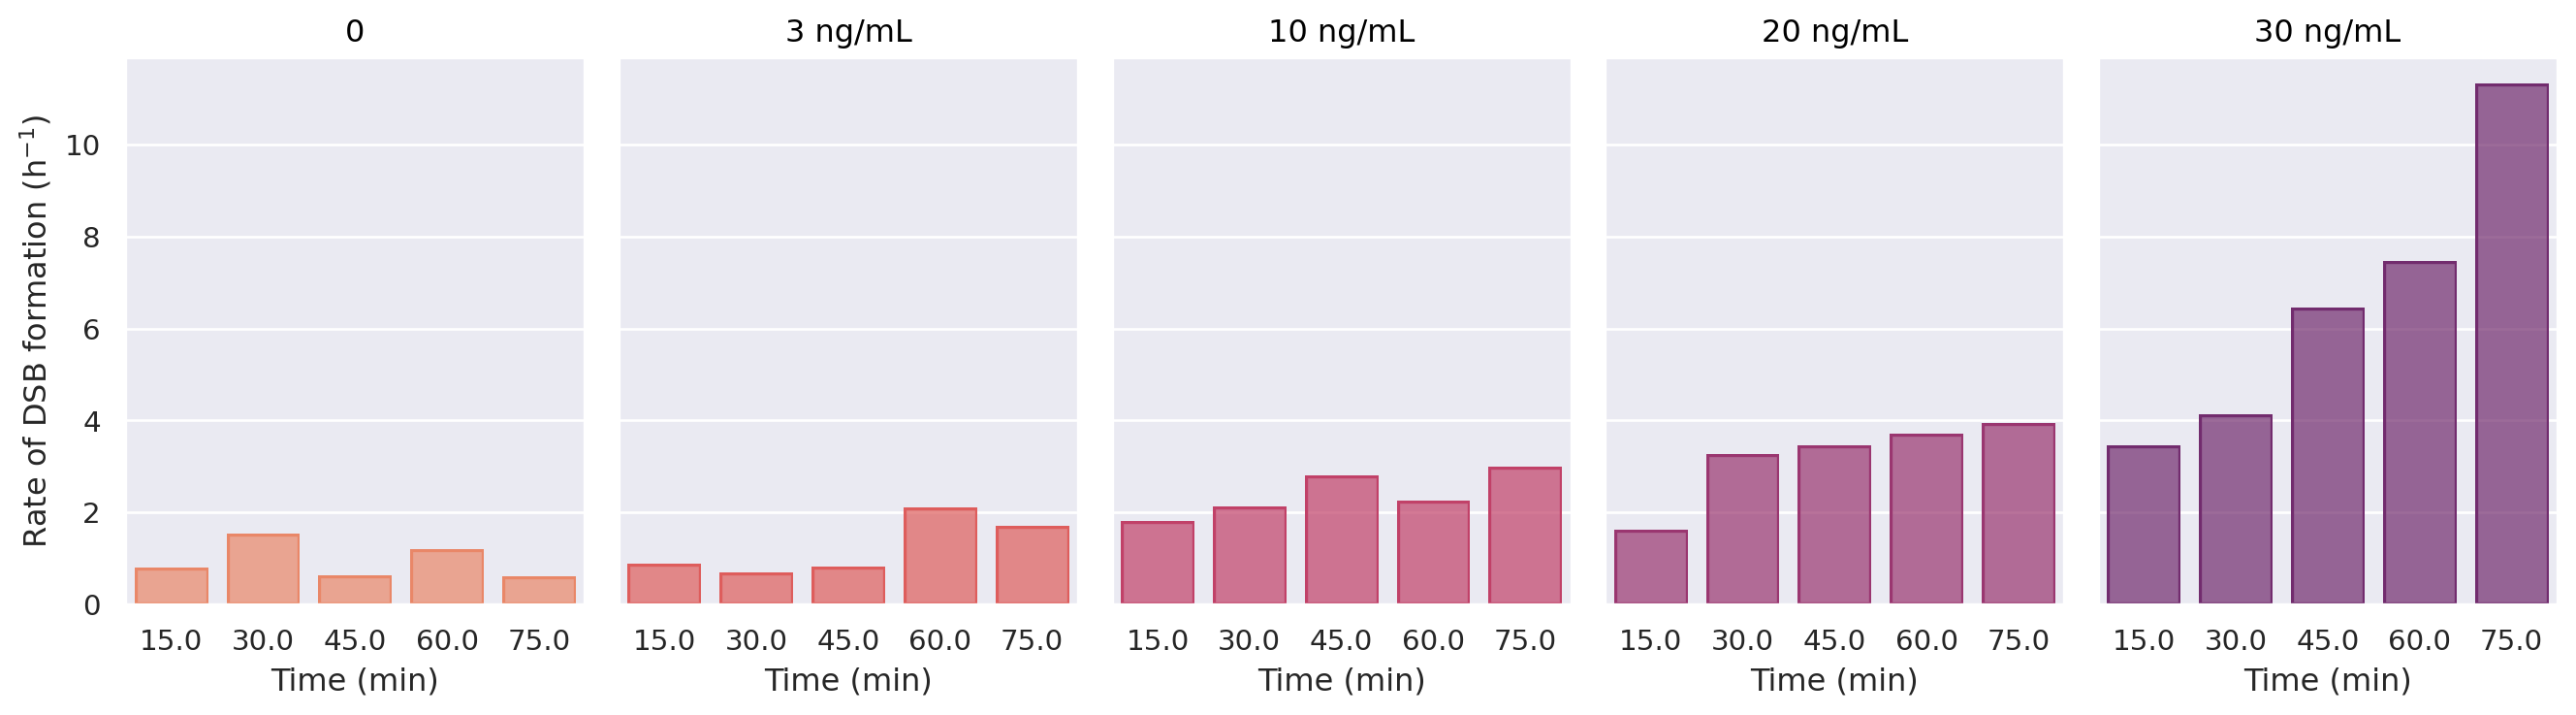

In [36]:
df = (data
      .RecB_spots
      .query('Time_min_bin < 90 and Frame > 0')
      .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('str'))
      .groupby(by=['Group', 'Time_min_bin', 'ParentIndices'], observed=True)
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Time_min_bin'], observed=True)
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('str'))
             .groupby(['Group', 'Time_min_bin'], observed=True)
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Group', 'Time_min_bin'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes_timepoints
             .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('str'))
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),
             on=['Group', 'Time_min_bin']
             )
      .assign(DSB_rate=lambda df: df.norm_count /98*60*60 *df.long_lived)  # Rate of DSB formation (h-1)
      )

(
    so.Plot(df, x='Time_min_bin', y='DSB_rate', color='Group')
    .layout(size=(14,4))
    .facet(col='Group', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'])
    .add(so.Bar(), so.Agg(), legend=False)
    .scale(color=so.Nominal('flare', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL']))
    .limit(y=(0, None))
    .label(x="Time (min)", y="RecB recruitment rate (h$^{-1}$)", color='Ciprofloxacin')
    # .theme(plotting_context('talk'))
#     .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/DSB_rate.svg', format='svg', bbox_inches='tight')
)